In [ ]:
!pip install tensorflow==2.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 102.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 109.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 67.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existin

In [ ]:
!pip install tensorflow-quantum

ERROR: Could not find a version that satisfies the requirement tensorflow-quantum (from versions: none)
ERROR: No matching distribution found for tensorflow-quantum


In [ ]:
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py'>

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

ModuleNotFoundError: No module named 'tensorflow_quantum'

In [ ]:
qubit = cirq.GridQubit(0, 0)

circuit1 = cirq.Circuit(cirq.X(qubit))
circuit2 = cirq.Circuit(cirq.H(qubit))

input_circuit_tensor = tfq.convert_to_tensor([circuit1, circuit2])

y_circuit = cirq.Circuit(cirq.Y(qubit))

y_appender = tfq.layers.AddCircuit()

output_circuit_tensor = y_appender(input_circuit_tensor, append=y_circuit)

In [ ]:
print(tfq.from_tensor(input_circuit_tensor))

[cirq.Circuit([
     cirq.Moment(
         cirq.X(cirq.GridQubit(0, 0)),
     ),
 ])
 cirq.Circuit([
     cirq.Moment(
         cirq.H(cirq.GridQubit(0, 0)),
     ),
 ])                                   ]


In [ ]:
print(tfq.from_tensor(output_circuit_tensor))

[cirq.Circuit([
     cirq.Moment(
         cirq.X(cirq.GridQubit(0, 0)),
     ),
     cirq.Moment(
         cirq.Y(cirq.GridQubit(0, 0)),
     ),
 ])
 cirq.Circuit([
     cirq.Moment(
         cirq.H(cirq.GridQubit(0, 0)),
     ),
     cirq.Moment(
         cirq.Y(cirq.GridQubit(0, 0)),
     ),
 ])                                   ]


In [ ]:
def generate_data(qubits):
    n_rounds = 20  # Produces n_rounds * n_qubits datapoints.
    excitations = []
    labels = []
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else -1)

    split_ind = int(len(excitations) * 0.8)
    train_excitations = excitations[:split_ind]
    test_excitations = excitations[split_ind:]

    train_labels = labels[:split_ind]
    test_labels = labels[split_ind:]

    return tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
        tfq.convert_to_tensor(test_excitations), np.array(test_labels)

In [ ]:
sample_points, sample_labels, _, __ = generate_data(cirq.GridQubit.rect(1, 4))
print('Input:', tfq.from_tensor(sample_points)[0], 'Output:', sample_labels[0])
print('Input:', tfq.from_tensor(sample_points)[1], 'Output:', sample_labels[1])

Input: (0, 0): ───X^-0.124─── Output: 1
Input: (0, 1): ───X^0.394─── Output: 1


In [ ]:
def cluster_state_circuit(bits):
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


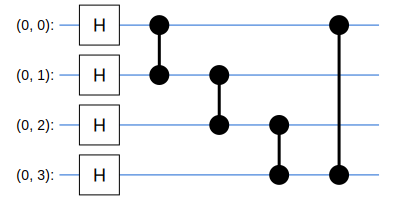

In [ ]:
SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(1, 4)))

In [ ]:
def one_qubit_unitary(bit, symbols):
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

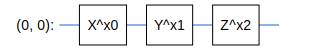

In [ ]:
SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0), sympy.symbols('x0:3')))

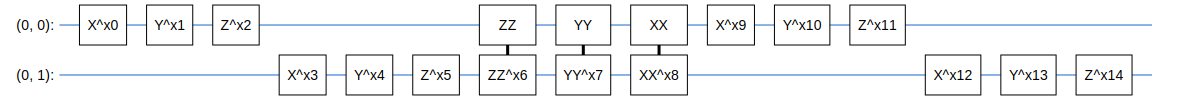

In [ ]:
SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:15')))

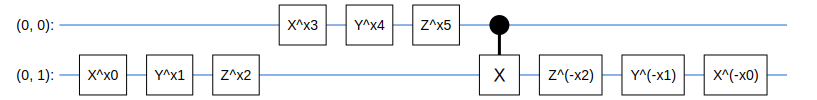

In [ ]:
SVGCircuit(two_qubit_pool(*cirq.GridQubit.rect(1, 2), sympy.symbols('x0:6')))

In [ ]:
def quantum_conv_circuit(bits, symbols):
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

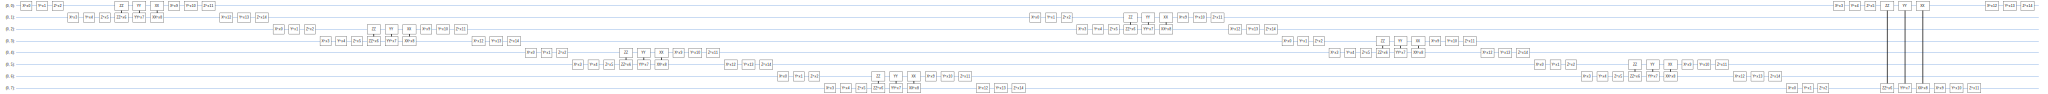

In [ ]:
SVGCircuit(
    quantum_conv_circuit(cirq.GridQubit.rect(1, 8), sympy.symbols('x0:15')))

In [ ]:
def quantum_pool_circuit(source_bits, sink_bits, symbols):
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

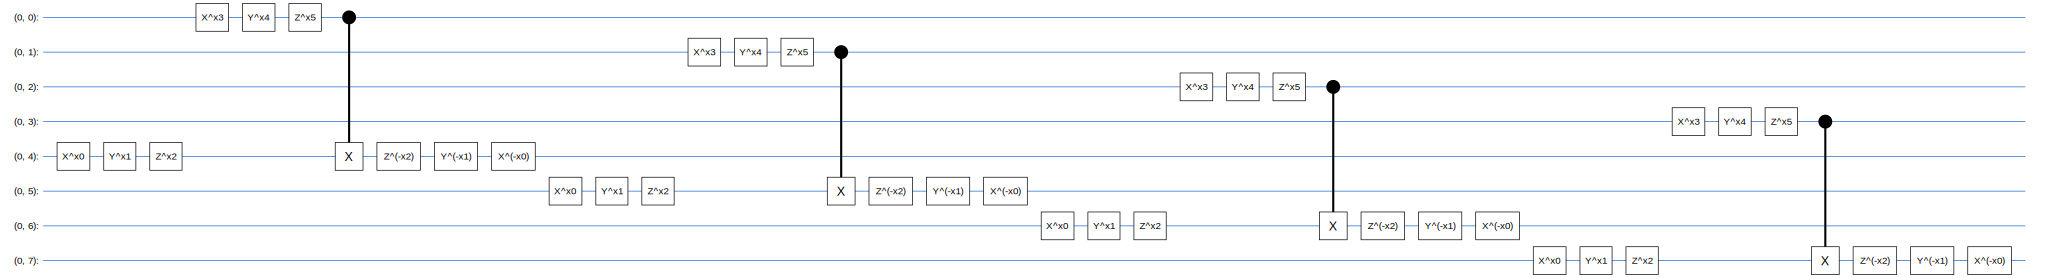

In [ ]:
test_bits = cirq.GridQubit.rect(1, 8)

SVGCircuit(
    quantum_pool_circuit(test_bits[:4], test_bits[4:], sympy.symbols('x0:6')))

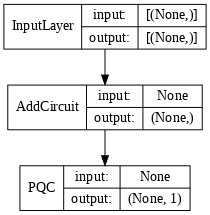

In [ ]:
def create_model_circuit(qubits):
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:63')
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:],
                                          symbols[15:21])
    model_circuit += quantum_conv_circuit(qubits[4:], symbols[21:36])
    model_circuit += quantum_pool_circuit(qubits[4:6], qubits[6:],
                                          symbols[36:42])
    model_circuit += quantum_conv_circuit(qubits[6:], symbols[42:57])
    model_circuit += quantum_pool_circuit([qubits[6]], [qubits[7]],
                                          symbols[57:63])
    return model_circuit


cluster_state_bits = cirq.GridQubit.rect(1, 8)
readout_operators = cirq.Z(cluster_state_bits[-1])

excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
cluster_state = tfq.layers.AddCircuit()(
    excitation_input, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model = tfq.layers.PQC(create_model_circuit(cluster_state_bits),
                               readout_operators)(cluster_state)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])

tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

In [ ]:
train_excitations, train_labels, test_excitations, test_labels = generate_data(
    cluster_state_bits)


@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))


qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy])

history = qcnn_model.fit(x=train_excitations,
                         y=train_labels,
                         batch_size=16,
                         epochs=500,
                         verbose=1,
                         validation_data=(test_excitations, test_labels))

Epoch 1/500
8/8 [==============================] - 3s 265ms/step - loss: 0.9145 - custom_accuracy: 0.7188 - val_loss: 0.8853 - val_custom_accuracy: 0.7500
Epoch 2/500
8/8 [==============================] - 2s 239ms/step - loss: 0.8296 - custom_accuracy: 0.7734 - val_loss: 0.7827 - val_custom_accuracy: 0.7812
Epoch 3/500
8/8 [==============================] - 2s 227ms/step - loss: 0.7404 - custom_accuracy: 0.8047 - val_loss: 0.6731 - val_custom_accuracy: 0.8125
Epoch 4/500
8/8 [==============================] - 2s 232ms/step - loss: 0.6550 - custom_accuracy: 0.8438 - val_loss: 0.6485 - val_custom_accuracy: 0.7812
Epoch 5/500
8/8 [==============================] - 2s 221ms/step - loss: 0.6358 - custom_accuracy: 0.8516 - val_loss: 0.6142 - val_custom_accuracy: 0.8750
Epoch 6/500
8/8 [==============================] - 2s 233ms/step - loss: 0.6141 - custom_accuracy: 0.8750 - val_loss: 0.6414 - val_custom_accuracy: 0.8438
Epoch 7/500
8/8 [==============================] - 2s 231ms/step - los

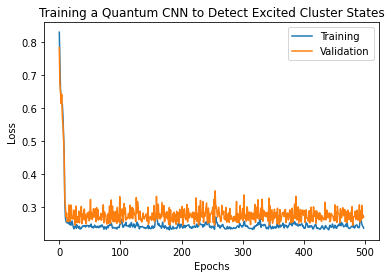

In [ ]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Training a Quantum CNN to Detect Excited Cluster States')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

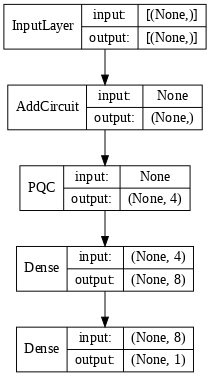

In [ ]:
readouts = [cirq.Z(bit) for bit in cluster_state_bits[4:]]


def multi_readout_model_circuit(qubits):
    """Make a model circuit with less quantum pool and conv operations."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:21')
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:],
                                          symbols[15:21])
    return model_circuit


excitation_input_dual = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

cluster_state_dual = tfq.layers.AddCircuit()(
    excitation_input_dual, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model_dual = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_dual)

d1_dual = tf.keras.layers.Dense(8)(quantum_model_dual)

d2_dual = tf.keras.layers.Dense(1)(d1_dual)

hybrid_model = tf.keras.Model(inputs=[excitation_input_dual], outputs=[d2_dual])

tf.keras.utils.plot_model(hybrid_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

In [ ]:
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                     loss=tf.losses.mse,
                     metrics=[custom_accuracy])

hybrid_history = hybrid_model.fit(x=train_excitations,
                                  y=train_labels,
                                  batch_size=16,
                                  epochs=500,
                                  verbose=1,
                                  validation_data=(test_excitations,
                                                   test_labels))

Epoch 1/500
8/8 [==============================] - 3s 109ms/step - loss: 0.9470 - custom_accuracy: 0.4609 - val_loss: 0.7665 - val_custom_accuracy: 0.6250
Epoch 2/500
8/8 [==============================] - 1s 93ms/step - loss: 0.7052 - custom_accuracy: 0.7500 - val_loss: 0.5640 - val_custom_accuracy: 0.9375
Epoch 3/500
8/8 [==============================] - 1s 89ms/step - loss: 0.3907 - custom_accuracy: 0.9375 - val_loss: 0.2565 - val_custom_accuracy: 1.0000
Epoch 4/500
8/8 [==============================] - 1s 91ms/step - loss: 0.2144 - custom_accuracy: 0.9922 - val_loss: 0.3454 - val_custom_accuracy: 0.9062
Epoch 5/500
8/8 [==============================] - 1s 94ms/step - loss: 0.2153 - custom_accuracy: 0.9766 - val_loss: 0.2144 - val_custom_accuracy: 0.9688
Epoch 6/500
8/8 [==============================] - 1s 94ms/step - loss: 0.1964 - custom_accuracy: 0.9766 - val_loss: 0.2761 - val_custom_accuracy: 1.0000
Epoch 7/500
8/8 [==============================] - 1s 92ms/step - loss: 0.1

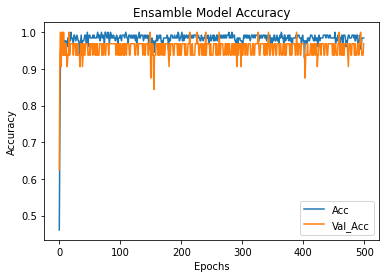

In [ ]:
plt.plot(hybrid_history.history['custom_accuracy'], label='Acc')
plt.plot(hybrid_history.history['val_custom_accuracy'], label='Val_Acc')
plt.title('Ensamble Model Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Accuracy')
plt.show()

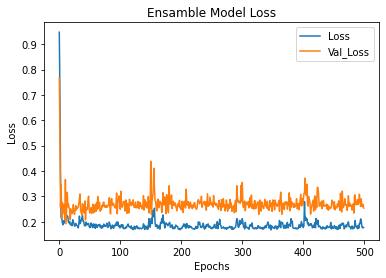

In [ ]:
plt.plot(hybrid_history.history['loss'], label='Loss')
plt.plot(hybrid_history.history['val_loss'], label='Val_Loss')
plt.title('Ensamble Model Loss')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Loss')
plt.show()